In [ ]:
using PyPlot
include("../saltsolver.jl")
include("../passive.jl")

function mirrorflip(E)
    Eaug = [E[end]; E]
    flipdim(Eaug,1)[2:end]
end

function coefs(f, Es)
    dot(Es[1], f)/norm(Es[1])^2, dot(Es[2], f)/norm(Es[2])^2
end

In [ ]:
n = 5
N = n * 30
L = 1.0
h = L/N
x = linspace(h, L, N)
F = 1 + 0.2 * cos(2π*n*x)
M = zeros(N, N)
laplacian!(J) = periodic!(J, h)
laplacian!(M)
Λ, X = eig(M)
reverse!(Λ)
X = X[:, reverse(1:N)]
ωs = √-Λ;

In [ ]:
ieig = 4
ℓ = 2
Ee, Eo = X[:, ieig], X[:, ieig+1]
ω = ωs[ieig]
plot(x, Ee, x, Eo)
println("ω = ", ω)
println("<Ee | Eo> = ", dot(Ee, Eo))

In [ ]:
ωa = 12.0
γ⟂ = 1.0
ɛ = (1 + im*0.3) * ones(N)
las = Laser(ɛ, F, ωa, γ⟂)
pmd = PassiveMode(copy(Ee), ω)
D = 0.3
passive_solve!(laplacian!, pmd, las, D, isprint=true)
imag(pmd.ω)

In [ ]:
Dt = passive_threshold!(laplacian!, pmd, las, (D, D*1.05))
ωt = real(pmd.ω)
println("imag(ω) = ", imag(pmd.ω))
println("note: mode no longer exactly symmetric")

In [ ]:
pmdchiral = PassiveMode(project_chiral(pmd.E, n, ℓ), pmd.ω)
passive_solve!(laplacian!, pmdchiral, las, Dt, isprint=true)
println("instantly solved")
E₊ = copy(pmdchiral.E)
E₋ = mirrorflip(E₊)
Ep = E₊ + E₋
Em = E₊ - E₋;
println("also, recall that for ℓ≠4, Ee and Eo not rotations of one another")
println(norm(Ep - mirrorflip(Ep)))
println(norm(Em + mirrorflip(Em)))
H, Is, Js, Ks, GD = overlap_integrals((E₊, E₋), ωt, Dt, las, n, ℓ, L);

In [ ]:
I, J, K = Is[1], Js[1], Ks[1]
ω1_circ = -imag(GD/I)/imag(H/I)
a_circ = sqrt(real((ω1_circ*H+GD)/I))
ω1_stand = -imag(GD/(2I+J))/imag(H/(2I+J))
a_stand = sqrt(real((ω1_stand*H+GD)/(2I+J)));

In [22]:
csq = 0.01
d = 0.01
D = Dt*(1+d)
md_circ = Mode(copy(E₊), ωt, csq)
md_stand = Mode(E₊ + E₋, ωt, csq)
solve!(laplacian!, md_circ, las, D)
solve!(laplacian!, md_stand, las, D);

In [40]:
npts = 12
ds = linspace(0, 0.01, npts)
dωs_circ = zeros(ds)
dωs_stand = zeros(ds)
calculate_stability_eigs = false
if calculate_stability_eigs
    Λs_circ = zeros(Complex{Float64}, length(ds), 4)
    Λs_stand = zeros(Complex{Float64}, length(ds), 4)
else
    edata = readdlm("eigs_data.txt");
    Λs_circ = edata[1:npts, :] + 1im * edata[npts+1:2npts, :]
    Λs_stand = edata[2npts+1:3npts, :] + 1im * edata[3npts+1:4npts, :]
end
as_circ₊, as_circ₋ = zeros(ds), zeros(ds)
as_stand₊, as_stand₋ = zeros(ds), zeros(ds)
γpar = γ⟂/10
for (i, d) in enumerate(ds)
    if i==1
        continue
    end
    D = Dt * (1+d)
    solve!(laplacian!, md_circ, las, D)
    solve!(laplacian!, md_stand, las, D)    
    coef₊, coef₋ = coefs(sqrt(md_circ.c²)*md_circ.E, (E₊, E₋))
    as_circ₊[i], as_circ₋[i] = abs(coef₊), abs(coef₋)
    coef₊, coef₋ = coefs(sqrt(md_stand.c²)*md_stand.E, (E₊, E₋))    
    as_stand₊[i], as_stand₋[i] = abs(coef₊), abs(coef₋)
    dωs_circ[i] = md_circ.ω - ωt
    dωs_stand[i] = md_stand.ω - ωt  
    if calculate_stability_eigs
        println("step ", i, " / ", npts)
        Λs_circ[i, :] = smallest_stability_eigs(laplacian!, 
        sqrt(md_circ.c²) * md_circ.E, md_circ.ω, D, γpar, las.ɛ)
        Λs_stand[i, :] = smallest_stability_eigs(laplacian!, 
        sqrt(md_stand.c²) * md_stand.E, md_stand.ω, D, γpar, las.ɛ)
    end
end
if calculate_stability_eigs
    eigs_data = [real(Λs_circ); imag(Λs_circ); real(Λs_stand); imag(Λs_stand)]
    writedlm("eigs_data.txt", eigs_data);
end

In [ ]:
# circulating stability eigenvalues
th1 = zeros(ds)
th2 = 2*imag(I/H)*a_circ^2 * ds
th3 = (imag(J/H) + sqrt(0.0im + abs(K/H)^2 - real(J/H)^2)) * a_circ^2 * ds
th4 = (imag(J/H) - sqrt(0.0im + abs(K/H)^2 - real(J/H)^2)) * a_circ^2 * ds
plot(ds, th1, "b-", ds, th2, "b-", ds, real(th3), "b-", ds, real(th4), "b-",
ds, real(Λs_circ[:, 1]), "rs", ds, real(Λs_circ[:, 2]), "rs", 
ds, real(Λs_circ[:, 3]), "rs", ds, real(Λs_circ[:, 4]), "rs")
rc("font", size=16)
xticks([])
yticks(linspace(-0.02, 0.004, 7))
ylabel(L"\mathrm{Re}(\sigma)", fontsize=24)
title(L"stability eigenvalues for $\mathbf{E}_+$", fontsize=22)
tight_layout()
savefig("n5circ_stability.pdf")

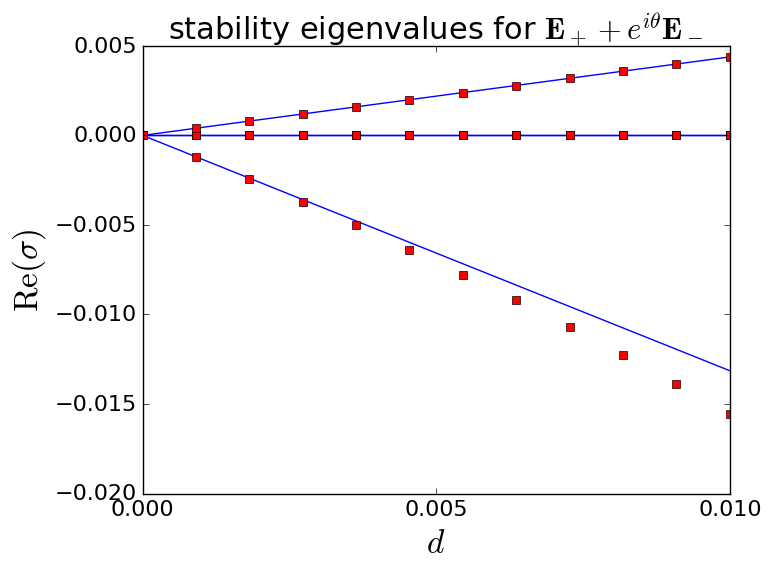

In [71]:
# standing stability eigenvalues
th1 = zeros(ds)
th2 = zeros(ds)
th3 = 2*imag((2I+J)/H) * a_stand^2 * ds
th4 = -2*imag(J/H) * a_stand^2 * ds
plot(ds, th1, "b-", ds, th2, "b-", ds, real(th3), "b-", ds, real(th4), "b-",
ds, real(Λs_stand[:, 1]), "rs", ds, real(Λs_stand[:, 2]), "rs", 
ds, real(Λs_stand[:, 3]), "rs", ds, real(Λs_stand[:, 4]), "rs")
rc("font", size=16)
xticks(linspace(0, 0.01, 3))
xlabel(L"d", fontsize=24)
ylabel(L"\mathrm{Re}(\sigma)", fontsize=24)
#title(L"stability eigenvalues for $\mathbf{E}_+$", fontsize=22)
title(L"stability eigenvalues for $\mathbf{E}_+ + e^{i\theta} \mathbf{E}_-$", fontsize=22)
tight_layout()
savefig("n5stand_stability.pdf")

In [ ]:
plot(ds, as_circ₊.^2, "o", ds, a_circ^2 * ds, "-",
ds, as_stand₊.^2, "s", ds, a_stand^2 * ds, "-")
rc("font", size=16)
xticks([])
yticks(linspace(0, 0.012, 4))
text(0.007, 0.001, L"\mathbf{E}_+ + e^{i\theta} \mathbf{E}_-", fontsize=24)
text(0.004, 0.006, L"\mathbf{E}_+", fontsize=24)
text(0.003, 0.01, "lines: perturbation theory", fontsize=20)
#xlabel(L"d", fontsize=24)
ylabel(L"\mathrm{amplitude}^2\equiv|a|^2d", fontsize=24)
tight_layout()
savefig("n5amp.pdf")

In [ ]:
plot(ds, ω1_circ*ds, "-", ds, dωs_circ, "o", ds, dωs_stand, "s")
ticklabel_format(style="sci", axis="y", scilimits=(0,0))
rc("font", size=16)
xticks(linspace(0, 0.01, 3))
yticks(linspace(-2e-6, 0, 6))
text(0.0065, -0.9e-6, L"\mathbf{E}_+ + e^{i\theta} \mathbf{E}_-", fontsize=24)
text(0.007, -1.4e-6, L"\mathbf{E}_+", fontsize=24)
#text(0.001, -1.8e-6, "line: perturbation theory", fontsize=20)
xlabel(L"d", fontsize=24)
ylabel(L"\omega - \omega_\mathrm{t}", fontsize=24)
tight_layout()
savefig("n5omega.pdf")